# Fitting hidden Markov models to spiking data

In this tutorial, we first generate data from a network of Leaky Integrate and Fire (LIF) neurons. Then we fit different kinds of hidden Markov models to the simulated data. This code was written by Lia Papadopoulos for this [github repo](https://github.com/lia-papadopoulos/PROJ_optimalCoding_arousal). Please cite the paper Papadopoulos et al., [Modulation of metastable ensemble dynamics explains optimal coding at moderate arousal in auditory cortex](https://pmc.ncbi.nlm.nih.gov/articles/PMC11014582/)  

- Network architecture: $N_e=1600$ and $N_i=400$ excitatory and inhibitory neurons are arranged into 20 clusters with strengthened intra-cluster couplings.

- The network generates metastable dynamics switching between different attractors, where each attractor is defined as a set of co-active clusters.

- The goal of the hidden Markov model is to identify intervals where each attractors is active, with a different hidden state per attractor.

- We will compare three HMM observations: Poisson, Bernoulli, and categorical.

In [ ]:
#@title Installing repo and dependencies if using colab (restart Colab Runtime after installing). Skip to imports if running locally.
 
!pip install -U matplotlib &> /dev/null
!git clone https://github.com/mazzulab/ssm &> /dev/null
!pip install git+https://github.com/mazzulab/ssm.git &> /dev/null
!git clone https://github.com/mazzulab/tutorial_dyn_sys_neuro.git
import sys
sys.path.insert(0,'/content/tutorial_dyn_sys_neuro')

In [51]:
#%% IMPORTS


# standard
import time
import numpy as np
import sys
from scipy.io import savemat
from scipy.io import loadmat
import matplotlib.pyplot as plt
# import simParams
# simulation parameters
from simParams import sim_params

# simulation functions
from fcn_make_network_cluster import fcn_make_network_cluster
from fcn_simulation import fcn_simulate_exact_poisson
from fcn_stimulation import get_stimulated_clusters


#%% SETTING UP...


# path for saving data
outpath = ''

def run_simulation(ICSeed):
    # seed for external input realization
    extInput_seed = 1342134

    # seed for selecting stimulated clusters
    stimClusters_seed = 12421

    # seed for stimulation
    stimSeed = 23423

    # seed for initial conditions and poisson process
    # ICSeed = 8485

    # seed for making the network
    networkSeed = 34524


    #%% UPDATE SIMULATION PARAMETERS


    # initialize parameters
    s_params = sim_params()

    # update synaptic weights
    s_params.update_JplusAB()

    # set dependent variables
    s_params.set_dependent_vars()

    # set external inputs     
    s_params.set_external_inputs(extInput_seed) 

    # make network
    W, popsizeE, popsizeI = fcn_make_network_cluster(s_params, networkSeed)  

    # set selective clusters
    selectiveClusters = get_stimulated_clusters(s_params, stimClusters_seed)
    
    # set selective clusters
    s_params.selectiveClusters = selectiveClusters[0]
        
    # determine which neurons are stimulated
    s_params.get_stimulated_neurons(stimSeed, popsizeE, popsizeI)
        
    # determine maximum stimulus strength
    s_params.set_max_stim_rate()


    #%% RUN THE SIMULATION


    t0 = time.time()

    if s_params.save_voltage == True:
        sys.exit('dont save voltage data')
    else:
        spikes = fcn_simulate_exact_poisson(s_params, W, ICSeed)
                
    tf = time.time()

    print('simulation done') 
    print('sim time = %0.3f seconds' %(tf-t0))

            
    #%% 
    #--------------------------------------------------------------------------
    # SAVE THE DATA
    #-------------------------------------------------------------------------- 

            
    results_dictionary = {'sim_params':                     s_params, \
                        'spikes':                         spikes, \
                        'W':                              W, \
                        'clust_sizeE':                    popsizeE, \
                        'clust_sizeI':                    popsizeI, \
                        'extInput_seed':                  extInput_seed, \
                        'stimClusters_seed':              stimClusters_seed,\
                        'stimSeed':                       stimSeed, \
                        'ICSeed':                         ICSeed, \
                        'networkSeed':                    networkSeed}
    return results_dictionary

ICSeed=845
data=run_simulation(ICSeed)

# # filename              
# if s_params.sd_nu_ext_e_pert == 0.:
    
#     filename = ('%srestCondition_spontaneous.mat' % (outpath))      
    
# else:
    
#     filename = ('%srunCondition_spontaneous.mat' % (outpath))      
    
# savemat(filename, results_dictionary)
# print('results written to file')




sim_params class initialized
Vr_e = 0.000
Vr_i = 0.000
Vth_e = 1.500
Vth_i = 0.750
tau_m_e = 0.02000 s
tau_m_i = 0.02000 s
tau_s_e = 0.00500 s
tau_s_i = 0.00500 s
tau_r = 0.00500 s
simulation done
sim time = 3.817 seconds


In [52]:
def compute_spike_counts(spikes, binsize=0.02):
    """
    Estimate spike counts in bins of given size and return a T x N array.
    
    Parameters:
    spikes (numpy array): 2D array with first row as spike times in seconds and second row as neuron IDs.
    binsize (float): Size of the bins in seconds. Default is 20ms.
    
    Returns:
    numpy array: T x N array with spike counts, where T is the number of bins and N is the number of neurons.
    """
    # Extract spike times and neuron IDs
    spike_times = spikes[0]
    neuron_ids = spikes[1].astype(int)
    
    # Determine the number of unique neurons
    unique_neurons = np.unique(neuron_ids)
    num_neurons = len(unique_neurons)
    
    # Map neuron IDs to a continuous range starting from 0
    neuron_id_map = {neuron_id: i for i, neuron_id in enumerate(unique_neurons)}
    mapped_neuron_ids = np.array([neuron_id_map[neuron_id] for neuron_id in neuron_ids])
    
    # Convert spike times to bin indices
    spike_bins = (spike_times / binsize).astype(int)
    
    # Determine the number of bins
    num_bins = spike_bins.max() + 1
    
    # Initialize the T x N array with zeros
    spike_counts = np.zeros((num_bins, num_neurons), dtype=int)
    
    # Use np.add.at to accumulate spike counts
    np.add.at(spike_counts, (spike_bins, mapped_neuron_ids), 1)
    
    return spike_counts

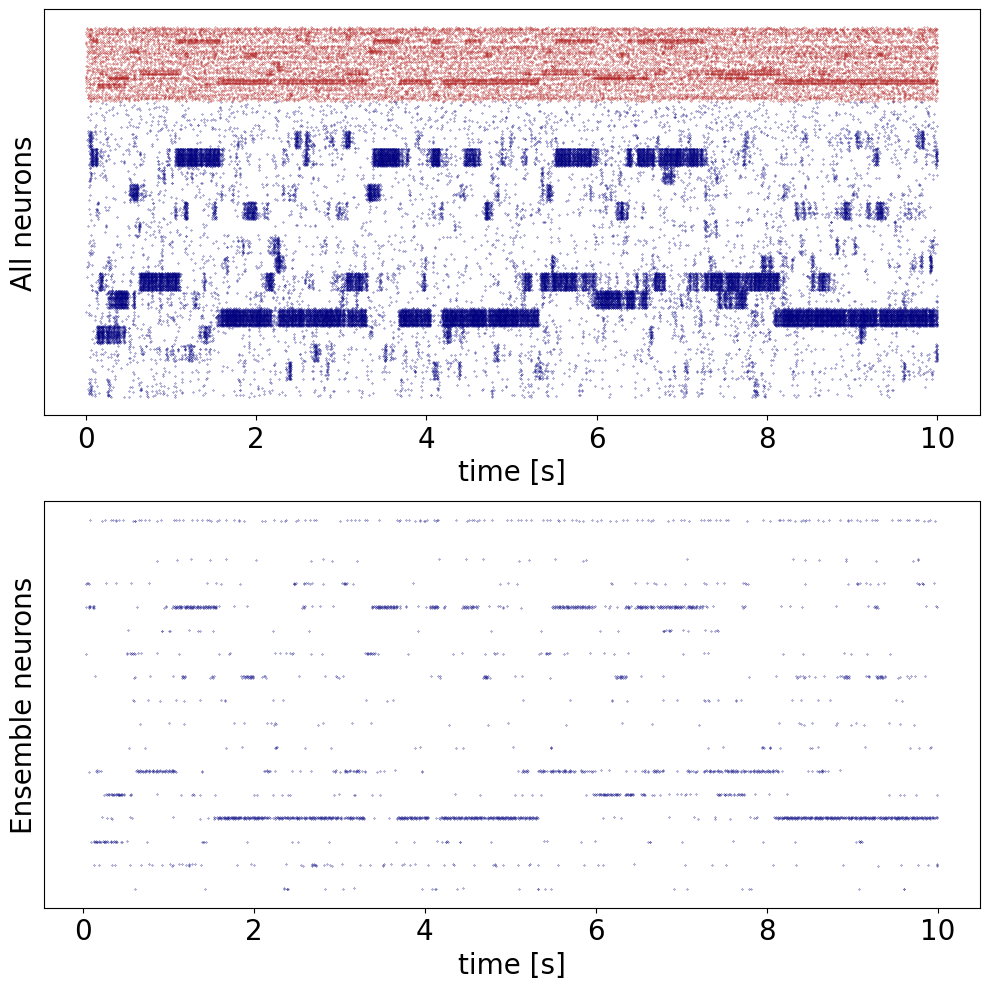

In [75]:
# load params and spikes

params = data['sim_params']
spikes_data = data['spikes']
N_e = params.N_e
N_i = params.N_i

binsize=0.01

# Randomly select a few neurons per cluster
np.random.seed(42)  # For reproducibility
popsizeE=data['clust_sizeE']
selected_neurons=np.sort(np.ravel([np.cumsum(popsizeE)+2,np.cumsum(popsizeE)+3,np.cumsum(popsizeE)+5]))
neuron_ids=spikes_data[1].astype(int)
selected_indices = np.isin(neuron_ids, selected_neurons)
spikes = spikes_data[:,selected_indices]


fig, axs = plt.subplots(2, 1, figsize=(10, 10))
fntsz=20
# plot all network neurons
indsE = np.nonzero(spikes_data[1,:] < N_e)[0]
indsI = np.nonzero(spikes_data[1,:] >= N_e)[0]
axs[0].plot(spikes_data[0,indsE],spikes_data[1,indsE], '.', markersize=0.5, color='navy')
axs[0].plot(spikes_data[0,indsI],spikes_data[1,indsI], '.', markersize=0.5, color='firebrick')
axs[0].set_yticks([])
axs[0].set_xlabel('time [s]', fontsize=fntsz)
axs[0].set_ylabel('All neurons', fontsize=fntsz)
axs[0].tick_params(axis='x', labelsize=fntsz)

# plot selected neurons
axs[1].plot(spikes[0,:],spikes[1,:], '.', markersize=0.5, color='navy')
axs[1].set_yticks([])
axs[1].set_xlabel('time [s]', fontsize=fntsz)
axs[1].set_ylabel('Ensemble neurons', fontsize=fntsz)
axs[1].tick_params(axis='x', labelsize=fntsz)

plt.tight_layout()
plt.show()

# Fit Poisson HMM to spikes one trial

- Bin spiking activity with binsize steps
- Fit the Poisson HMM
- Plot posterior probabilities of hidden states

In [76]:
import ssm
from ssm import HMM
N_iters=200
tolerance=10**-4

In [77]:
# Convert spike times from seconds to 20ms bins
binsize=0.001
spike_counts = compute_spike_counts(spikes, binsize=binsize)

# choose 10 states arbitrarily 
num_states=20
time_bins,num_neurons=spike_counts.shape
simple_hmm = ssm.HMM(num_states,
                     num_neurons,
                     observations="poisson",
                     transitions="standard",num_iters=N_iters,tolerance=tolerance,verbose=1)

lls = simple_hmm.fit(spike_counts, method='em', num_iters=N_iters)



  0%|          | 0/200 [00:00<?, ?it/s]

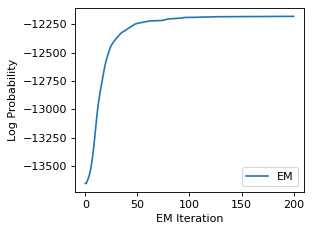

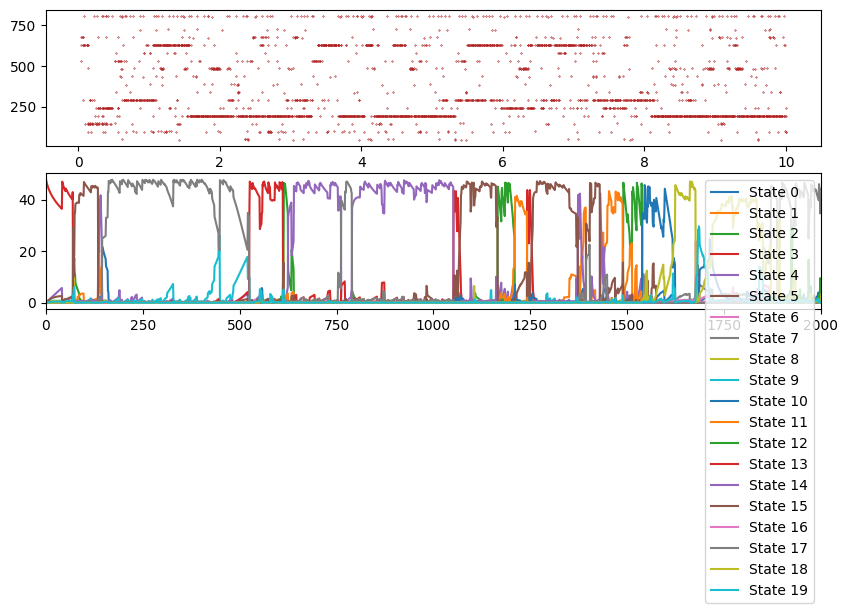

In [78]:
# Plot the log probabilities of the true and fit models. Fit model final LL should be greater 
# than or equal to true LL.
fig = plt.figure(figsize=(4, 3), dpi=80, facecolor='w', edgecolor='k')
plt.plot(lls, label="EM")
plt.legend(loc="lower right")
plt.xlabel("EM Iteration")
plt.ylabel("Log Probability")
plt.tight_layout()

posterior = simple_hmm.filter(spike_counts)
plt.figure(figsize=(10, 6))
plt.subplot(3,1,1)
# plt.plot(spikes[0,indsE],spikes[1,indsE], '.', markersize=0.5, color='navy')
plt.plot(spikes[0,:],spikes[1,:], '.', markersize=0.5, color='firebrick')
plt.plot(spikes[0,:],spikes[1,:], '.', markersize=0.5, color='firebrick')
plt.subplot(3,1,2)
for i in range(num_states):
    plt.plot(num_neurons*posterior[:,i], label="State %d" % i)
plt.xlim([0, 2/binsize])
plt.legend(loc='upper right')

plt.savefig("hmm_sim_poisson.pdf")

In [ ]:
from ssm import utilplot

gen_trans_mat = np.exp(simple_hmm.transitions.log_Ps)

plt.subplot(1, 1, 1)
utilplot.plot_trans_matrix(gen_trans_mat)
plt.title("Generative transition matrix", fontsize = 15)
plt.colorbar()

utilplot.plt.subplots_adjust(0, 0, 1, 1)